In [7]:
import pickle
import requests
from bs4 import BeautifulSoup
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import diagnostic_plots
import unicodedata

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cross_validation import KFold
from sklearn.model_selection import learning_curve
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

with open('all_top40.pkl', 'rb') as picklefile:
    df2 = pickle.load(picklefile)

In [8]:
under_100 = df2[df2['Salary'] < 500000]

In [9]:
under_100

,index,Games_Played,Plate_Appearances,At_Bats,Runs,Hits,2B,3B,HR,RBI,...,HBP,SF,dWAR,Salary,Adj_Salary,Age,All_star_count,Total_games_played,Team,Pos
Player_Name,,,,,,,,,,,,,,,,,,,,,
Gordon Beckham,314.0,104.285714,366.285714,330.571429,38.857143,76.714286,17.142857,0.285714,7.285714,31.857143,...,5.285714,3.142857,0.242857,100000.0,0.014691,30,0.0,730,SEA,4
Jeremy Hellickson,395.0,13.500000,26.833333,22.333333,1.166667,3.666667,0.333333,0.166667,0.000000,2.166667,...,0.333333,0.166667,0.000000,100000.0,0.014691,30,0.0,81,WSN,1
Matt Albers,563.0,19.400000,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,200000.0,0.029382,34,0.0,97,MIL,1
Oliver Perez,645.0,37.333333,0.500000,0.500000,0.166667,0.333333,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.016667,100000.0,0.014691,35,0.0,224,CLE,1
Wade LeBlanc,804.0,17.833333,10.166667,8.666667,0.666667,2.000000,0.166667,0.000000,0.000000,0.333333,...,0.166667,0.000000,0.000000,50000.0,0.007346,32,0.0,107,SEA,1


In [10]:
df2 = df2.rename(index=str, columns={"2B": "Doubles", "3B": "Triples"})
df2.loc[:,'rootASC'] = df2.loc[:,'All_star_count'] ** 0.5

In [11]:
df2['Salary'].describe()

count    5.960000e+02
mean     5.273218e+06
std      6.778023e+06
min      5.000000e+04
25%      5.700000e+05
50%      2.175000e+06
75%      7.108928e+06
max      3.557143e+07
Name: Salary, dtype: float64

In [12]:
batters_only = df2[df2['Pos'] != '1']

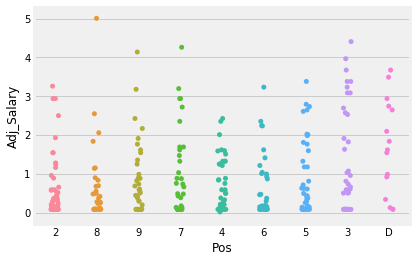

In [13]:
sns.stripplot(x="Pos", y="Adj_Salary", data=batters_only)

In [14]:
batters_only = pd.get_dummies(data=batters_only, columns=['Pos'], drop_first=True)

In [15]:
batters_only.head()

,index,Games_Played,Plate_Appearances,At_Bats,Runs,Hits,Doubles,Triples,HR,RBI,...,Team,rootASC,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_D
Player_Name,,,,,,,,,,,,,,,,,,,,,
A.J. Ellis,1.0,78.571429,282.714286,239.428571,24.0,56.285714,9.857143,0.428571,6.142857,28.142857,...,SDP,0.0,0,0,0,0,0,0,0,0
A.J. Pollock,3.0,87.333333,341.166667,310.666667,51.0,89.000000,20.500000,4.000000,8.833333,33.166667,...,ARI,1.0,0,0,0,0,0,1,0,0
Aaron Altherr,5.0,51.250000,201.250000,178.000000,26.5,43.250000,10.250000,2.250000,7.000000,27.250000,...,PHI,0.0,0,0,0,0,0,0,1,0
Aaron Hicks,7.0,91.600000,330.000000,289.400000,38.6,67.000000,12.200000,1.400000,8.600000,32.200000,...,NYY,0.0,0,0,0,0,0,1,0,0
Aaron Judge,8.0,91.000000,386.500000,313.000000,69.0,84.500000,13.000000,1.500000,28.000000,62.000000,...,NYY,1.0,0,0,0,0,0,0,1,0


In [16]:
batters_only['DH'] = batters_only['Pos_D']
batters_only['First_Base'] = batters_only['Pos_3']
batters_only['Second_Base'] = batters_only['Pos_4']
batters_only['Third_Base'] = batters_only['Pos_5']
batters_only['Shortstop'] = batters_only['Pos_6']
batters_only['Left_Field'] = batters_only['Pos_7']
batters_only['Center_Field'] = batters_only['Pos_8']
batters_only['Right_Field'] = batters_only['Pos_9']

batters_only = batters_only.drop(['Pos_3','Pos_4','Pos_5','Pos_6','Pos_7','Pos_8','Pos_9','Pos_D'],1)

batters_only

,index,Games_Played,Plate_Appearances,At_Bats,Runs,Hits,Doubles,Triples,HR,RBI,...,Team,rootASC,DH,First_Base,Second_Base,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field
Player_Name,,,,,,,,,,,,,,,,,,,,,
A.J. Ellis,1.0,78.571429,282.714286,239.428571,24.000000,56.285714,9.857143,0.428571,6.142857,28.142857,...,SDP,0.000000,0,0,0,0,0,0,0,0
A.J. Pollock,3.0,87.333333,341.166667,310.666667,51.000000,89.000000,20.500000,4.000000,8.833333,33.166667,...,ARI,1.000000,0,0,0,0,0,0,1,0
Aaron Altherr,5.0,51.250000,201.250000,178.000000,26.500000,43.250000,10.250000,2.250000,7.000000,27.250000,...,PHI,0.000000,0,0,0,0,0,0,0,1
Aaron Hicks,7.0,91.600000,330.000000,289.400000,38.600000,67.000000,12.200000,1.400000,8.600000,32.200000,...,NYY,0.000000,0,0,0,0,0,0,1,0
Aaron Judge,8.0,91.000000,386.500000,313.000000,69.000000,84.500000,13.000000,1.500000,28.000000,62.000000,...,NYY,1.000000,0,0,0,0,0,0,0,1
Abraham Almonte,12.0,60.400000,189.800000,172.400000,23.000000,42.400000,10.800000,2.000000,2.800000,16.800000,...,KCR,0.000000,0,0,0,0,0,0,1,0
Adam Duvall,15.0,90.500000,351.000000,319.000000,44.250000,76.750000,18.000000,2.250000,18.000000,54.000000,...,CIN,1.000000,0,0,0,0,0,1,0,0
Adam Eaton,16.0,90.666667,403.333333,356.833333,58.000000,101.500000,17.166667,5.833333,6.000000,31.666667,...,WSN,0.000000,0,0,0,0,0,0,0,1
Adam Engel,17.0,97.000000,336.000000,301.000000,34.000000,50.000000,11.000000,3.000000,6.000000,21.000000,...,CHW,0.000000,0,0,0,0,0,0,1,0


In [17]:
batters_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, A.J. Ellis to Yuli Gurriel
Data columns (total 36 columns):
index                 340 non-null float64
Games_Played          340 non-null float64
Plate_Appearances     340 non-null float64
At_Bats               340 non-null float64
Runs                  340 non-null float64
Hits                  340 non-null float64
Doubles               340 non-null float64
Triples               340 non-null float64
HR                    340 non-null float64
RBI                   340 non-null float64
BA                    340 non-null float64
OBP                   340 non-null float64
SLG                   340 non-null float64
OPS                   340 non-null float64
SB                    340 non-null float64
BB                    340 non-null float64
SO                    340 non-null float64
TB                    340 non-null float64
HBP                   340 non-null float64
SF                    340 non-null float64
dWAR                  

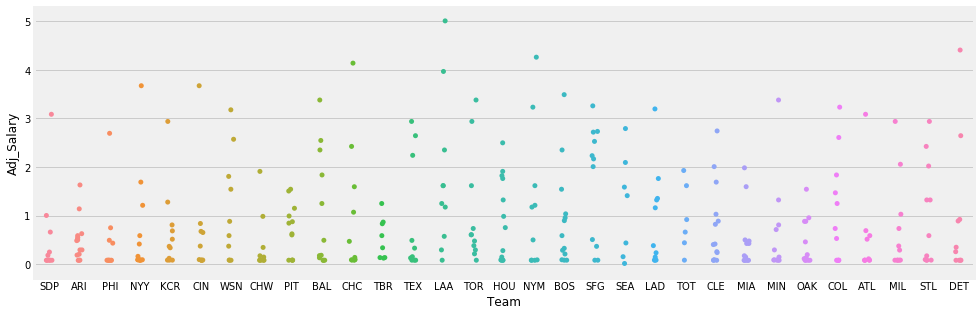

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
sns.stripplot(x="Team", y="Adj_Salary", data=batters_only, ax=ax)

In [19]:
salary_df = batters_only.sort_values(by='Salary', ascending=False)
salary_df[:10]

,index,Games_Played,Plate_Appearances,At_Bats,Runs,Hits,Doubles,Triples,HR,RBI,...,Team,rootASC,DH,First_Base,Second_Base,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field
Player_Name,,,,,,,,,,,,,,,,,,,,,
Mike Trout,613.0,132.142857,580.714286,485.571429,98.857143,148.571429,28.571429,5.714286,28.714286,81.285714,...,LAA,2.449490,0,0,0,0,0,0,1,0
Miguel Cabrera,599.0,148.000000,634.428571,550.428571,90.000000,176.571429,35.285714,0.571429,30.714286,104.857143,...,DET,2.449490,0,1,0,0,0,0,0,0
Yoenis Cespedes,829.0,131.333333,549.833333,503.166667,75.333333,138.000000,27.666667,4.000000,25.666667,82.500000,...,NYM,1.414214,0,0,0,0,0,1,0,0
Jason Heyward,377.0,137.285714,554.142857,492.428571,69.000000,127.714286,24.428571,3.000000,13.857143,55.428571,...,CHC,0.000000,0,0,0,0,0,0,0,1
Albert Pujols,34.0,145.285714,629.428571,571.142857,76.714286,152.571429,27.571429,0.142857,29.428571,98.285714,...,LAA,1.000000,0,1,0,0,0,0,0,0
Giancarlo Stanton,312.0,126.571429,532.000000,459.714286,75.857143,123.857143,25.857143,1.285714,35.000000,87.571429,...,NYY,2.000000,1,0,0,0,0,0,0,0
Joey Votto,417.0,139.142857,610.142857,490.571429,85.000000,153.571429,33.000000,1.571429,23.857143,76.000000,...,CIN,2.000000,0,1,0,0,0,0,0,0
J.D. Martinez,342.0,110.285714,445.428571,404.000000,55.857143,115.000000,24.000000,1.857143,21.714286,68.000000,...,BOS,1.000000,1,0,0,0,0,0,0,0
Josh Donaldson,446.0,136.166667,594.000000,512.166667,87.500000,142.500000,29.666667,2.000000,28.833333,87.333333,...,TOR,1.732051,0,0,0,1,0,0,0,0


In [20]:
batters_only_df = batters_only[['Runs', 'Hits', 'Doubles', 'Triples', 'HR', 'RBI', 'BA', 'OBP', 'SLG',
                                'OPS', 'SB', 'TB', 'SF', 'Age', 'Total_games_played',
                                'dWAR','All_star_count','First_Base','Second_Base','Third_Base',
                                'Shortstop','Left_Field','Center_Field','Right_Field','DH','Team','Salary']]

([<matplotlib.axis.YTick at 0x1c2411a198>,
 <a list of 7 Text yticklabel objects>)

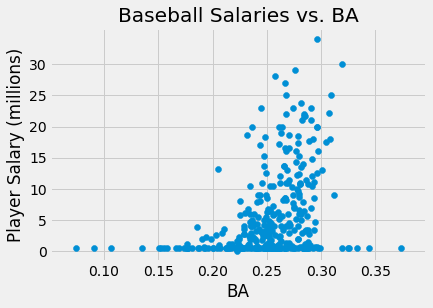

In [21]:
import matplotlib.style as style
style.use('fivethirtyeight')

y_ticks = [0, .5e7, 1e7, 1.5e7, 2e7, 2.5e7, 3e7]
salaries = ['0', '5', '10', '15','20','25','30']

plt.scatter(batters_only_df['BA'], batters_only_df['Salary'])
plt.title('Baseball Salaries vs. BA')
plt.ylabel('Player Salary (millions)')
plt.xlabel('BA');
plt.yticks(y_ticks, salaries)

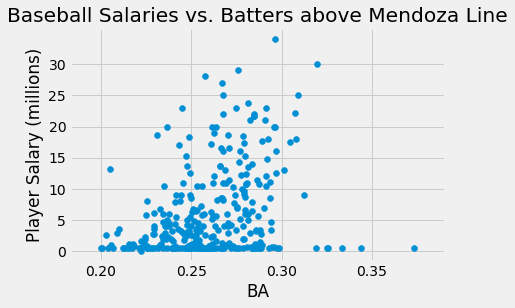

In [22]:
## Remove players below Mendoza line

batters_only_df = batters_only_df[batters_only_df['BA'] > 0.2]

y_ticks = [0, .5e7, 1e7, 1.5e7, 2e7, 2.5e7, 3e7]
salaries = ['0', '5', '10', '15','20','25','30']

plt.scatter(batters_only_df['BA'], batters_only_df['Salary'])
plt.title('Baseball Salaries vs. Batters above Mendoza Line')
plt.ylabel('Player Salary (millions)')
plt.xlabel('BA')
plt.yticks(y_ticks, salaries);

In [23]:
no_categorical = batters_only_df[['Runs', 'Hits', 'Doubles', 'Triples', 'HR', 'RBI',
                                  'BA', 'OBP', 'SLG', 'OPS', 'SB', 'TB', 'SF', 'Salary',
                                  'Age', 'Total_games_played', 'dWAR', 'All_star_count']]

In [24]:
batters_only_df

,Runs,Hits,Doubles,Triples,HR,RBI,BA,OBP,SLG,OPS,...,First_Base,Second_Base,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field,DH,Team,Salary
Player_Name,,,,,,,,,,,,,,,,,,,,,
A.J. Ellis,24.000000,56.285714,9.857143,0.428571,6.142857,28.142857,0.233300,0.336991,0.354413,0.691404,...,0,0,0,0,0,0,0,0,SDP,1250000.0
A.J. Pollock,51.000000,89.000000,20.500000,4.000000,8.833333,33.166667,0.273747,0.335573,0.443354,0.778927,...,0,0,0,0,0,1,0,0,ARI,7750000.0
Aaron Hicks,38.600000,67.000000,12.200000,1.400000,8.600000,32.200000,0.229163,0.315112,0.364295,0.679407,...,0,0,0,0,0,1,0,0,NYY,2825000.0
Aaron Judge,69.000000,84.500000,13.000000,1.500000,28.000000,62.000000,0.231352,0.342493,0.486272,0.828766,...,0,0,0,0,0,0,1,0,NYY,622300.0
Abraham Almonte,23.000000,42.400000,10.800000,2.000000,2.800000,16.800000,0.248115,0.301156,0.382594,0.683751,...,0,0,0,0,0,1,0,0,KCR,825000.0
Adam Duvall,44.250000,76.750000,18.000000,2.250000,18.000000,54.000000,0.225049,0.284313,0.451360,0.735673,...,0,0,0,0,1,0,0,0,CIN,645000.0
Adam Eaton,58.000000,101.500000,17.166667,5.833333,6.000000,31.666667,0.279859,0.362290,0.415633,0.777923,...,0,0,0,0,0,0,1,0,WSN,6000000.0
Adam Frazier,38.000000,78.000000,14.000000,3.500000,4.000000,32.000000,0.288616,0.350310,0.404987,0.755297,...,0,1,0,0,0,0,0,0,PIT,571000.0
Adam Jones,85.857143,170.428571,28.857143,1.714286,28.714286,86.714286,0.278898,0.317446,0.472643,0.790088,...,0,0,0,0,0,1,0,0,BAL,17333333.0


In [25]:
#sns.pairplot(batters_only_df, size=1.2, aspect=1.5)

In [26]:
## NO ARIZONA FOR NOW

categorical_data = batters_only_df[['First_Base','Second_Base','Third_Base','Shortstop',
                                    'Left_Field', 'Right_Field','Center_Field','DH','Team']]

categorical_data

,First_Base,Second_Base,Third_Base,Shortstop,Left_Field,Right_Field,Center_Field,DH,Team
Player_Name,,,,,,,,,
A.J. Ellis,0,0,0,0,0,0,0,0,SDP
A.J. Pollock,0,0,0,0,0,0,1,0,ARI
Aaron Hicks,0,0,0,0,0,0,1,0,NYY
Aaron Judge,0,0,0,0,0,1,0,0,NYY
Abraham Almonte,0,0,0,0,0,0,1,0,KCR
Adam Duvall,0,0,0,0,1,0,0,0,CIN
Adam Eaton,0,0,0,0,0,1,0,0,WSN
Adam Frazier,0,1,0,0,0,0,0,0,PIT
Adam Jones,0,0,0,0,0,0,1,0,BAL


In [27]:
## FROM BEFORE!!1

#y = norm_batters.log_salary
#X = norm_batters.drop(['log_salary','Salary'],1)
#X_train, X_FINALTEST, y_train, y_FINALTEST = train_test_split(X, y, test_size=0.3, random_state=55)

In [28]:
training_df = batters_only_df.copy(deep=True)

In [29]:
#training_df.drop(columns='index', inplace=True)

training_df

,Runs,Hits,Doubles,Triples,HR,RBI,BA,OBP,SLG,OPS,...,First_Base,Second_Base,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field,DH,Team,Salary
Player_Name,,,,,,,,,,,,,,,,,,,,,
A.J. Ellis,24.000000,56.285714,9.857143,0.428571,6.142857,28.142857,0.233300,0.336991,0.354413,0.691404,...,0,0,0,0,0,0,0,0,SDP,1250000.0
A.J. Pollock,51.000000,89.000000,20.500000,4.000000,8.833333,33.166667,0.273747,0.335573,0.443354,0.778927,...,0,0,0,0,0,1,0,0,ARI,7750000.0
Aaron Hicks,38.600000,67.000000,12.200000,1.400000,8.600000,32.200000,0.229163,0.315112,0.364295,0.679407,...,0,0,0,0,0,1,0,0,NYY,2825000.0
Aaron Judge,69.000000,84.500000,13.000000,1.500000,28.000000,62.000000,0.231352,0.342493,0.486272,0.828766,...,0,0,0,0,0,0,1,0,NYY,622300.0
Abraham Almonte,23.000000,42.400000,10.800000,2.000000,2.800000,16.800000,0.248115,0.301156,0.382594,0.683751,...,0,0,0,0,0,1,0,0,KCR,825000.0
Adam Duvall,44.250000,76.750000,18.000000,2.250000,18.000000,54.000000,0.225049,0.284313,0.451360,0.735673,...,0,0,0,0,1,0,0,0,CIN,645000.0
Adam Eaton,58.000000,101.500000,17.166667,5.833333,6.000000,31.666667,0.279859,0.362290,0.415633,0.777923,...,0,0,0,0,0,0,1,0,WSN,6000000.0
Adam Frazier,38.000000,78.000000,14.000000,3.500000,4.000000,32.000000,0.288616,0.350310,0.404987,0.755297,...,0,1,0,0,0,0,0,0,PIT,571000.0
Adam Jones,85.857143,170.428571,28.857143,1.714286,28.714286,86.714286,0.278898,0.317446,0.472643,0.790088,...,0,0,0,0,0,1,0,0,BAL,17333333.0


In [30]:
training_df.describe()

,Runs,Hits,Doubles,Triples,HR,RBI,BA,OBP,SLG,OPS,...,All_star_count,First_Base,Second_Base,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field,DH,Salary
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,...,313.000000,313.000000,313.000000,313.00000,313.000000,313.000000,313.000000,313.000000,313.000000,3.130000e+02
mean,45.790545,88.942431,17.743702,2.057797,11.664681,43.399293,0.260069,0.324026,0.422182,0.746208,...,0.712460,0.108626,0.124601,0.13099,0.115016,0.124601,0.099042,0.118211,0.047923,6.096712e+06
std,23.248438,42.615337,8.873908,1.619738,8.214783,23.950993,0.026149,0.031665,0.067438,0.088134,...,1.240504,0.311668,0.330794,0.33793,0.319552,0.330794,0.299196,0.323375,0.213946,6.988099e+06
min,1.000000,3.500000,0.000000,0.000000,0.000000,1.250000,0.200174,0.233271,0.285281,0.528143,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,27.000000,56.285714,10.500000,0.714286,5.000000,23.200000,0.242623,0.304292,0.381773,0.686618,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,5.850000e+05
50%,44.600000,90.000000,17.857143,1.714286,10.000000,41.666667,0.259717,0.322596,0.416449,0.742242,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.300000e+06
75%,62.857143,123.857143,24.500000,3.166667,16.428571,59.571429,0.278925,0.343541,0.458537,0.791047,...,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000e+06
max,106.333333,181.500000,38.714286,8.142857,39.000000,104.857143,0.373162,0.454545,0.779729,1.232323,...,6.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,3.408300e+07


In [31]:
training_df.columns

Index(['Runs', 'Hits', 'Doubles', 'Triples', 'HR', 'RBI', 'BA', 'OBP', 'SLG',
       'OPS', 'SB', 'TB', 'SF', 'Age', 'Total_games_played', 'dWAR',
       'All_star_count', 'First_Base', 'Second_Base', 'Third_Base',
       'Shortstop', 'Left_Field', 'Center_Field', 'Right_Field', 'DH', 'Team',
       'Salary'],
      dtype='object')

In [32]:
#y_train = pd.DataFrame(y_train)

In [33]:
#y_train.reset_index(inplace=True)

#y_train

In [34]:
## CREATE FULL TRAINING DATASET

#training_df.reset_index(inplace=True)

#training_df = pd.merge(training_df, y_train)

#training_df = training_df.set_index('Player_Name')

In [35]:
training_df

,Runs,Hits,Doubles,Triples,HR,RBI,BA,OBP,SLG,OPS,...,First_Base,Second_Base,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field,DH,Team,Salary
Player_Name,,,,,,,,,,,,,,,,,,,,,
A.J. Ellis,24.000000,56.285714,9.857143,0.428571,6.142857,28.142857,0.233300,0.336991,0.354413,0.691404,...,0,0,0,0,0,0,0,0,SDP,1250000.0
A.J. Pollock,51.000000,89.000000,20.500000,4.000000,8.833333,33.166667,0.273747,0.335573,0.443354,0.778927,...,0,0,0,0,0,1,0,0,ARI,7750000.0
Aaron Hicks,38.600000,67.000000,12.200000,1.400000,8.600000,32.200000,0.229163,0.315112,0.364295,0.679407,...,0,0,0,0,0,1,0,0,NYY,2825000.0
Aaron Judge,69.000000,84.500000,13.000000,1.500000,28.000000,62.000000,0.231352,0.342493,0.486272,0.828766,...,0,0,0,0,0,0,1,0,NYY,622300.0
Abraham Almonte,23.000000,42.400000,10.800000,2.000000,2.800000,16.800000,0.248115,0.301156,0.382594,0.683751,...,0,0,0,0,0,1,0,0,KCR,825000.0
Adam Duvall,44.250000,76.750000,18.000000,2.250000,18.000000,54.000000,0.225049,0.284313,0.451360,0.735673,...,0,0,0,0,1,0,0,0,CIN,645000.0
Adam Eaton,58.000000,101.500000,17.166667,5.833333,6.000000,31.666667,0.279859,0.362290,0.415633,0.777923,...,0,0,0,0,0,0,1,0,WSN,6000000.0
Adam Frazier,38.000000,78.000000,14.000000,3.500000,4.000000,32.000000,0.288616,0.350310,0.404987,0.755297,...,0,1,0,0,0,0,0,0,PIT,571000.0
Adam Jones,85.857143,170.428571,28.857143,1.714286,28.714286,86.714286,0.278898,0.317446,0.472643,0.790088,...,0,0,0,0,0,1,0,0,BAL,17333333.0


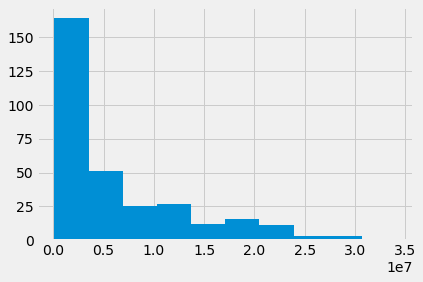

In [36]:
training_df.Salary.hist()

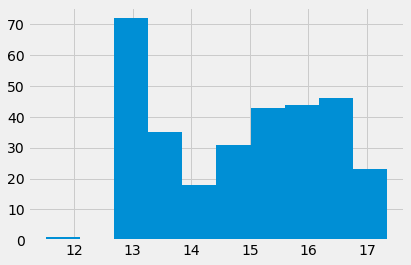

In [37]:
training_df['log_salary'] = np.log(training_df.Salary)

training_df.log_salary.hist()

In [38]:
from scipy import stats

y_transformed, _ = stats.boxcox(training_df.Salary)

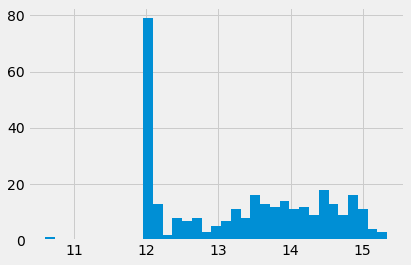

In [39]:
pd.Series(y_transformed).hist(bins=35)

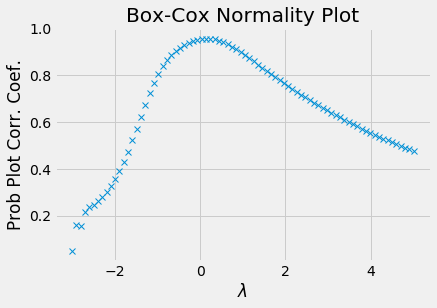

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(training_df.Salary, -3, 5, plot=ax)

0.15956245042037795


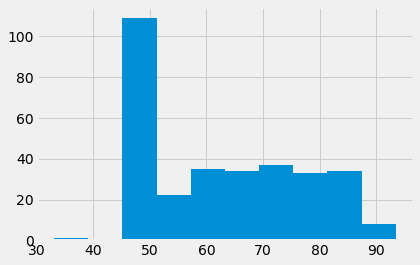

In [41]:
lamb=stats.boxcox_normmax(training_df.Salary, brack=(-1.9, 1.9))
print(lamb)
training_df['y_t']=(np.power(training_df.Salary,lamb)-1)/lamb

plt.hist(training_df['y_t']);

In [42]:
training_df.loc[:,'rootASC'] = training_df.loc[:,'All_star_count'] ** 0.5

In [43]:
training_df.corr()

,Runs,Hits,Doubles,Triples,HR,RBI,BA,OBP,SLG,OPS,...,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field,DH,Salary,log_salary,y_t,rootASC
Runs,1.000000,0.952016,0.921863,0.522089,0.794984,0.901047,0.375304,0.452044,0.373188,0.447963,...,0.038038,-0.017244,0.014587,0.016190,0.062249,0.066928,0.678559,0.706624,0.715791,0.676827
Hits,0.952016,1.000000,0.953036,0.507708,0.715878,0.893332,0.449801,0.399244,0.315299,0.384698,...,0.051213,0.032614,-0.022714,-0.029906,0.012670,0.064157,0.688901,0.744547,0.750115,0.666740
Doubles,0.921863,0.953036,1.000000,0.425870,0.729518,0.891904,0.409963,0.394282,0.358311,0.415827,...,0.106203,-0.011703,-0.014035,-0.065659,0.013132,0.054548,0.663336,0.713810,0.719812,0.650902
Triples,0.522089,0.507708,0.425870,1.000000,0.146114,0.276856,0.263860,0.125230,0.045353,0.079695,...,-0.053220,0.138741,0.080775,0.186183,0.098750,-0.142108,0.207633,0.286506,0.278638,0.211109
HR,0.794984,0.715878,0.729518,0.146114,1.000000,0.923620,0.208839,0.351632,0.591801,0.579163,...,0.081098,-0.123714,0.018918,-0.090712,0.055768,0.233357,0.583478,0.552996,0.568398,0.592420
RBI,0.901047,0.893332,0.891904,0.276856,0.923620,1.000000,0.338774,0.408037,0.490570,0.521970,...,0.092362,-0.064237,-0.009031,-0.108538,0.036067,0.170271,0.680111,0.678805,0.692177,0.666566
BA,0.375304,0.449801,0.409963,0.263860,0.208839,0.338774,1.000000,0.655835,0.577531,0.677539,...,0.064565,-0.035946,-0.005679,-0.051114,-0.005193,0.034762,0.322335,0.259883,0.276490,0.350941
OBP,0.452044,0.399244,0.394282,0.125230,0.351632,0.408037,0.655835,1.000000,0.519133,0.756506,...,0.023060,-0.115445,0.018682,-0.083277,0.024670,0.087364,0.397664,0.312823,0.333605,0.407177
SLG,0.373188,0.315299,0.358311,0.045353,0.591801,0.490570,0.577531,0.519133,1.000000,0.951685,...,0.101176,-0.154435,0.087966,-0.083366,0.051951,0.162347,0.281298,0.181874,0.202703,0.328427
OPS,0.447963,0.384698,0.415827,0.079695,0.579163,0.521970,0.677539,0.756506,0.951685,1.000000,...,0.085702,-0.159647,0.074021,-0.093709,0.048615,0.155612,0.358114,0.251556,0.274960,0.397594


In [44]:
training_df['Team'].unique()

array(['SDP', 'ARI', 'NYY', 'KCR', 'CIN', 'WSN', 'PIT', 'BAL', 'CHC',
       'TBR', 'TEX', 'LAA', 'TOR', 'HOU', 'NYM', 'BOS', 'PHI', 'SFG',
       'SEA', 'LAD', 'CHW', 'TOT', 'CLE', 'MIA', 'MIN', 'OAK', 'COL',
       'ATL', 'MIL', 'STL', 'DET'], dtype=object)

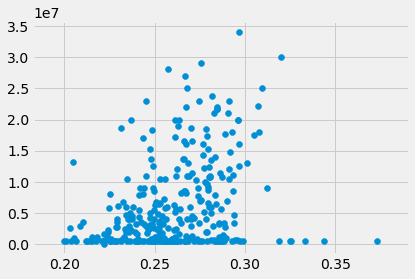

In [45]:
plt.scatter(training_df['BA'], training_df['Salary'])

In [46]:
#sns.pairplot(batters_only_df, size=1.2, aspect=1.5)

In [47]:
training_df

,Runs,Hits,Doubles,Triples,HR,RBI,BA,OBP,SLG,OPS,...,Shortstop,Left_Field,Center_Field,Right_Field,DH,Team,Salary,log_salary,y_t,rootASC
Player_Name,,,,,,,,,,,,,,,,,,,,,
A.J. Ellis,24.000000,56.285714,9.857143,0.428571,6.142857,28.142857,0.233300,0.336991,0.354413,0.691404,...,0,0,0,0,0,SDP,1250000.0,14.038654,52.604646,0.000000
A.J. Pollock,51.000000,89.000000,20.500000,4.000000,8.833333,33.166667,0.273747,0.335573,0.443354,0.778927,...,0,0,1,0,0,ARI,7750000.0,15.863203,72.499654,1.000000
Aaron Hicks,38.600000,67.000000,12.200000,1.400000,8.600000,32.200000,0.229163,0.315112,0.364295,0.679407,...,0,0,1,0,0,NYY,2825000.0,14.854019,60.784534,0.000000
Aaron Judge,69.000000,84.500000,13.000000,1.500000,28.000000,62.000000,0.231352,0.342493,0.486272,0.828766,...,0,0,0,1,0,NYY,622300.0,13.341178,46.404170,1.000000
Abraham Almonte,23.000000,42.400000,10.800000,2.000000,2.800000,16.800000,0.248115,0.301156,0.382594,0.683751,...,0,0,1,0,0,KCR,825000.0,13.623139,48.827989,0.000000
Adam Duvall,44.250000,76.750000,18.000000,2.250000,18.000000,54.000000,0.225049,0.284313,0.451360,0.735673,...,0,1,0,0,0,CIN,645000.0,13.377006,46.706144,1.000000
Adam Eaton,58.000000,101.500000,17.166667,5.833333,6.000000,31.666667,0.279859,0.362290,0.415633,0.777923,...,0,0,0,1,0,WSN,6000000.0,15.607270,69.347821,0.000000
Adam Frazier,38.000000,78.000000,14.000000,3.500000,4.000000,32.000000,0.288616,0.350310,0.404987,0.755297,...,0,0,0,0,0,PIT,571000.0,13.255144,45.686057,0.000000
Adam Jones,85.857143,170.428571,28.857143,1.714286,28.714286,86.714286,0.278898,0.317446,0.472643,0.790088,...,0,0,1,0,0,BAL,17333333.0,16.668142,83.294713,2.000000


In [48]:
training_df.corr()

,Runs,Hits,Doubles,Triples,HR,RBI,BA,OBP,SLG,OPS,...,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field,DH,Salary,log_salary,y_t,rootASC
Runs,1.000000,0.952016,0.921863,0.522089,0.794984,0.901047,0.375304,0.452044,0.373188,0.447963,...,0.038038,-0.017244,0.014587,0.016190,0.062249,0.066928,0.678559,0.706624,0.715791,0.676827
Hits,0.952016,1.000000,0.953036,0.507708,0.715878,0.893332,0.449801,0.399244,0.315299,0.384698,...,0.051213,0.032614,-0.022714,-0.029906,0.012670,0.064157,0.688901,0.744547,0.750115,0.666740
Doubles,0.921863,0.953036,1.000000,0.425870,0.729518,0.891904,0.409963,0.394282,0.358311,0.415827,...,0.106203,-0.011703,-0.014035,-0.065659,0.013132,0.054548,0.663336,0.713810,0.719812,0.650902
Triples,0.522089,0.507708,0.425870,1.000000,0.146114,0.276856,0.263860,0.125230,0.045353,0.079695,...,-0.053220,0.138741,0.080775,0.186183,0.098750,-0.142108,0.207633,0.286506,0.278638,0.211109
HR,0.794984,0.715878,0.729518,0.146114,1.000000,0.923620,0.208839,0.351632,0.591801,0.579163,...,0.081098,-0.123714,0.018918,-0.090712,0.055768,0.233357,0.583478,0.552996,0.568398,0.592420
RBI,0.901047,0.893332,0.891904,0.276856,0.923620,1.000000,0.338774,0.408037,0.490570,0.521970,...,0.092362,-0.064237,-0.009031,-0.108538,0.036067,0.170271,0.680111,0.678805,0.692177,0.666566
BA,0.375304,0.449801,0.409963,0.263860,0.208839,0.338774,1.000000,0.655835,0.577531,0.677539,...,0.064565,-0.035946,-0.005679,-0.051114,-0.005193,0.034762,0.322335,0.259883,0.276490,0.350941
OBP,0.452044,0.399244,0.394282,0.125230,0.351632,0.408037,0.655835,1.000000,0.519133,0.756506,...,0.023060,-0.115445,0.018682,-0.083277,0.024670,0.087364,0.397664,0.312823,0.333605,0.407177
SLG,0.373188,0.315299,0.358311,0.045353,0.591801,0.490570,0.577531,0.519133,1.000000,0.951685,...,0.101176,-0.154435,0.087966,-0.083366,0.051951,0.162347,0.281298,0.181874,0.202703,0.328427
OPS,0.447963,0.384698,0.415827,0.079695,0.579163,0.521970,0.677539,0.756506,0.951685,1.000000,...,0.085702,-0.159647,0.074021,-0.093709,0.048615,0.155612,0.358114,0.251556,0.274960,0.397594


In [49]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, A.J. Ellis to Yuli Gurriel
Data columns (total 30 columns):
Runs                  313 non-null float64
Hits                  313 non-null float64
Doubles               313 non-null float64
Triples               313 non-null float64
HR                    313 non-null float64
RBI                   313 non-null float64
BA                    313 non-null float64
OBP                   313 non-null float64
SLG                   313 non-null float64
OPS                   313 non-null float64
SB                    313 non-null float64
TB                    313 non-null float64
SF                    313 non-null float64
Age                   313 non-null int64
Total_games_played    313 non-null int64
dWAR                  313 non-null float64
All_star_count        313 non-null float64
First_Base            313 non-null uint8
Second_Base           313 non-null uint8
Third_Base            313 non-null uint8
Shortstop             313 non-nu

In [50]:
training_df['y_t']

Player_Name
A.J. Ellis            52.604646
A.J. Pollock          72.499654
Aaron Hicks           60.784534
Aaron Judge           46.404170
Abraham Almonte       48.827989
Adam Duvall           46.706144
Adam Eaton            69.347821
Adam Frazier          45.686057
Adam Jones            83.294713
Addison Russell       62.131424
Adeiny Hechavarria    69.145310
Adrian Beltre         83.835677
Albert Almora         45.880131
Albert Pujols         89.857764
Alcides Escobar       59.489603
Aledmys Diaz          57.189504
Alex Avila            64.610652
Alex Bregman          46.084428
Alex Gordon           85.363252
Amed Rosario          45.360464
Andrelton Simmons     77.026373
Andrew Benintendi     46.379831
Andrew Knapp          45.346347
Andrew McCutchen      81.017803
Andrew Romine         50.989391
Anthony Rendon        78.524287
Anthony Rizzo         71.727037
Anthony Santander     45.323779
Asdrubal Cabrera      73.289357
Austin Barnes         45.450986
                        ... 

In [51]:
## SET UP FINAL TRAIN/TEST

X = training_df.drop(['Salary', 'log_salary', 'y_t'], axis=1)
y = training_df['y_t']
X_train, X_FINALTEST, y_train, y_FINALTEST = train_test_split(X, y, test_size=0.3, random_state=55)

In [52]:
X_train.columns

Index(['Runs', 'Hits', 'Doubles', 'Triples', 'HR', 'RBI', 'BA', 'OBP', 'SLG',
       'OPS', 'SB', 'TB', 'SF', 'Age', 'Total_games_played', 'dWAR',
       'All_star_count', 'First_Base', 'Second_Base', 'Third_Base',
       'Shortstop', 'Left_Field', 'Center_Field', 'Right_Field', 'DH', 'Team',
       'rootASC'],
      dtype='object')

In [53]:
## NORMALIZE NON-CATEGORICAL VALUES

In [54]:
ssX = StandardScaler()
X_train_scalable = X_train.filter(['Runs', 'Hits', 'Doubles', 'Triples', 'HR', 'RBI',
                                  'BA', 'OBP', 'SLG', 'OPS', 'SB', 'TB', 'SF',
                                  'Age', 'Total_games_played', 'dWAR', 'All_star_count', 'rootASC'], axis=1)
X_train_scaled_columns = pd.DataFrame(ssX.fit_transform(X_train_scalable), columns = ['Runs_Scaled', 'Hits_Scaled',
                                'Doubles_Scaled','Triples_Scaled', 'HR_Scaled', 'RBI_Scaled', 'BA_Scaled', 'OBP_Scaled',
                                'SLG_Scaled', 'OPS_Scaled', 'SB_Scaled', 'TB_Scaled', 'SF_Scaled',
                                  'Age_Scaled', 'Total_games_played_Scaled', 'dWAR_Scaled', 'All_star_count_Scaled', 'rootASC_Scaled'])

X_train.reset_index(inplace=True)
X_train = X_train.join(X_train_scaled_columns)
X_train = X_train.drop(['Runs', 'Hits', 'Doubles', 'Triples', 'HR', 'RBI',
                                  'BA', 'OBP', 'SLG', 'OPS', 'SB', 'TB', 'SF',
                                  'Age', 'Total_games_played', 'dWAR', 'All_star_count','Team', 'rootASC'],1)

X_train = X_train.set_index('Player_Name')

X_test_scalable = X_FINALTEST.filter(['Runs', 'Hits', 'Doubles', 'Triples', 'HR', 'RBI',
                                  'BA', 'OBP', 'SLG', 'OPS', 'SB', 'TB', 'SF',
                                  'Age', 'Total_games_played', 'dWAR', 'All_star_count', 'rootASC'], axis=1)
X_test_scaled_columns = pd.DataFrame(ssX.transform(X_test_scalable), columns = ['Runs_Scaled', 'Hits_Scaled',
                                'Doubles_Scaled','Triples_Scaled', 'HR_Scaled', 'RBI_Scaled', 'BA_Scaled', 'OBP_Scaled',
                                'SLG_Scaled', 'OPS_Scaled', 'SB_Scaled', 'TB_Scaled', 'SF_Scaled',
                                  'Age_Scaled', 'Total_games_played_Scaled', 'dWAR_Scaled', 'All_star_count_Scaled', 'rootASC_Scaled'])

X_FINALTEST.reset_index(inplace=True)
X_FINALTEST = X_FINALTEST.join(X_test_scaled_columns)
X_FINALTEST = X_FINALTEST.drop(['Runs', 'Hits', 'Doubles', 'Triples', 'HR', 'RBI',
                                  'BA', 'OBP', 'SLG', 'OPS', 'SB', 'TB', 'SF',
                                  'Age', 'Total_games_played', 'dWAR', 'All_star_count','Team', 'rootASC'],1)

X_FINALTEST = X_FINALTEST.set_index('Player_Name')

In [55]:
X_train.head()

,First_Base,Second_Base,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field,DH,Runs_Scaled,Hits_Scaled,...,SLG_Scaled,OPS_Scaled,SB_Scaled,TB_Scaled,SF_Scaled,Age_Scaled,Total_games_played_Scaled,dWAR_Scaled,All_star_count_Scaled,rootASC_Scaled
Player_Name,,,,,,,,,,,,,,,,,,,,,
Craig Gentry,0,0,0,0,1,0,0,0,-0.946217,-1.120146,...,-1.541358,-1.342295,0.690017,-1.256630,-1.284347,1.432898,-0.018722,0.648005,-0.590827,-0.718119
Adrian Beltre,0,0,1,0,0,0,0,0,1.491664,1.826579,...,1.334324,1.426975,-0.726695,1.831397,2.080895,2.805622,1.453994,1.362468,1.692544,1.702153
Rougned Odor,0,1,0,0,0,0,0,0,0.850513,0.875137,...,0.268206,-0.155770,0.445921,1.105088,0.898512,-1.312550,0.117126,-0.582996,-0.590827,-0.718119
Mikie Mahtook,0,0,0,0,1,0,0,0,-0.666625,-0.766095,...,0.468648,0.145622,-0.413997,-0.689454,-1.011490,-0.214371,-0.904822,-0.954710,-0.590827,-0.718119
Starling Marte,0,0,0,0,0,1,0,0,0.748432,0.814926,...,0.177277,0.290835,3.182027,0.587824,-0.587045,0.060174,0.518495,1.072821,0.170297,0.679226


In [56]:
X_FINALTEST.head()

,First_Base,Second_Base,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field,DH,Runs_Scaled,Hits_Scaled,...,SLG_Scaled,OPS_Scaled,SB_Scaled,TB_Scaled,SF_Scaled,Age_Scaled,Total_games_played_Scaled,dWAR_Scaled,All_star_count_Scaled,rootASC_Scaled
Player_Name,,,,,,,,,,,,,,,,,,,,,
Pablo Sandoval,0,0,1,0,0,0,0,0,-0.071235,0.391507,...,-0.773423,-0.914342,-0.803274,0.269882,1.262322,0.609264,0.688305,-0.278867,0.931421,1.258025
Christian Vazquez,0,0,0,0,0,0,0,0,-0.793347,-0.672865,...,-1.131458,-1.079994,-0.548011,-0.870950,-0.587045,-0.488915,-0.917172,0.442033,-0.590827,-0.718119
Mike Zunino,0,0,0,0,0,0,0,0,-0.477951,-0.559436,...,-0.272102,-0.634502,-0.807103,-0.281996,-0.502156,-0.488915,-0.105171,0.396977,-0.590827,-0.718119
Jake Marisnick,0,0,0,0,0,1,0,0,-0.528640,-0.769203,...,-0.904673,-1.240539,0.667043,-0.758423,-0.374823,-0.488915,-0.142220,1.072821,-0.590827,-0.718119
Eric Thames,1,0,0,0,0,0,0,0,0.459788,0.096280,...,0.489930,0.284546,-0.548011,0.390447,-0.587045,0.609264,-0.583726,-1.991004,-0.590827,-0.718119


In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

## THIS IS JUST USING DEFAULTS FOR EACH TYPE -- NEED TO TUNE HYPERPARAMETERS

X_temptrain, X_temptest, y_temptrain, y_temptest = train_test_split(X_train, y_train, test_size=0.3, random_state=4444)

models = [LinearRegression(), SVR(), DecisionTreeRegressor(), RandomForestRegressor(),
           GradientBoostingRegressor()]
names = ['LinReg', 'SVR', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):    
    models[i].fit(X_temptrain, y_temptrain)
    
    score = np.round(models[i].score(X_temptest, y_temptest), 4)
    # Make predictions using the testing set
    y_predict = models[i].predict(X_temptest)
    # The mean squared error
    rmse = np.round(mean_squared_error(y_temptest, y_predict)**0.5, 4)
    # Explained variance score: 1 is perfect prediction
    rsquared = np.round(r2_score(y_temptest, y_predict), 4)
    print(f'{names[i]} R^2_score: {score} RMSE: {rmse}')
    print('')

LinReg R^2_score: 0.7715 RMSE: 7.3022

SVR R^2_score: 0.6617 RMSE: 8.8851

Decision Tree R^2_score: 0.7071 RMSE: 8.2683

Random Forest R^2_score: 0.8545 RMSE: 5.8281

Gradient Boosted Trees R^2_score: 0.8369 RMSE: 6.169



In [58]:
## Simple train-test-split

from sklearn.model_selection import GridSearchCV

models = [('Linear Regresion', LinearRegression),
          ('SVR', SVR),
          ('Decision Tree', DecisionTreeRegressor),
          ('Random Forest', RandomForestRegressor),
          ('Gradient Boosted Trees', GradientBoostingRegressor)
         ]

param_choices = [
    {},
    {
        'C': np.linspace(0.1,100,101)
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]
        
grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    grid.fit(X_temptrain, y_temptrain)
    y_pred = grid.predict(X_temptest)
    mse_score = -1.0*grid.score(X_temptest,y_temptest)
    rmse_score = np.sqrt(mse_score)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}, rmse: {rmse_score}"
    print(s)
    grids[name] = grid

Linear Regresion: best score: -54.46217092354418, best estimator: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), rmse: 7.302164264373172
SVR: best score: -47.79962564757136, best estimator: SVR(C=42.05800000000001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False), rmse: 7.511870121139806
Decision Tree: best score: -42.85211959707758, best estimator: DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'), rmse: 6.55806764061585
Random Forest: best score: -35.08065209967406, best estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
          

In [59]:
## USING KFOLD CROSS VALIDATION

models = [LinearRegression(), SVR(), DecisionTreeRegressor(), RandomForestRegressor(),
           GradientBoostingRegressor()]
names = ['LinReg', 'SVR', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(n=len(X_train), random_state = 4444)
    rsquared = []
    rmse = []
    
    for train_index, test_index in kf:
        
        kX_train = X_train.iloc[train_index]
        kX_test = X_train.iloc[test_index]
        ky_train = y_train.iloc[train_index]
        ky_test = y_train.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        #R_squared score
        score = np.round(models[i].score(kX_test, ky_test), 4)
        # Make predictions using the testing set
        y_predict = models[i].predict(kX_test)
        # The mean squared error
        root_mse = np.round(np.sqrt(mean_squared_error(ky_test, y_predict)), 4)
        
        rsquared.append(score)
        rmse.append(root_mse)
        
    
    rsquared = np.round(np.mean(rsquared), 4)
    rmse = np.round(np.mean(rmse), 4)
    
    print('Scores with K-Fold CV')
    print(f'{names[i]} R^2 score: {rsquared} RMSE: {rmse}')
    print('')

Scores with K-Fold CV
LinReg R^2 score: 0.7312 RMSE: 7.4303

Scores with K-Fold CV
SVR R^2 score: 0.5901 RMSE: 9.3253

Scores with K-Fold CV
Decision Tree R^2 score: 0.6878 RMSE: 8.1143

Scores with K-Fold CV
Random Forest R^2 score: 0.801 RMSE: 6.4146

Scores with K-Fold CV
Gradient Boosted Trees R^2 score: 0.7743 RMSE: 6.8167



In [60]:
models = [('forest', RandomForestRegressor)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    grid.fit(X_train, y_train)
    mse_score = -1.0*grid.best_score_
    rmse_score = np.sqrt(mse_score)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}, rmse: {rmse_score}"
    print(s)
    grids[name] = grid

forest: best score: -37.37802446409811, best estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False), rmse: 6.113756984383507


In [61]:
rf = grid.best_estimator_
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [62]:
models = [('GBT', GradientBoostingRegressor)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    grid.fit(X_train, y_train)
    mse_score = -1.0*grid.best_score_
    rmse_score = np.sqrt(mse_score)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}, rmse: {rmse_score}"
    print(s)
    grids[name] = grid

GBT: best score: -39.064648050807996, best estimator: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False), rmse: 6.250171841702274


In [63]:
gb = grid.best_estimator_
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [64]:
rf_residuals = np.linalg.norm(y_train - rf.predict(X_train)) ** 2

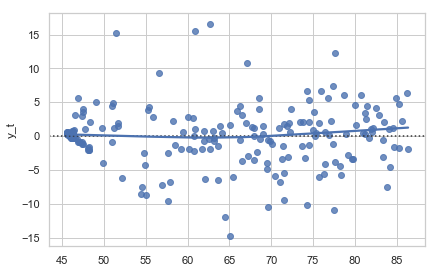

In [65]:
import seaborn as sns
sns.set(style="whitegrid")

y_predict = rf.predict(X_train)

# Plot the residuals after fitting a linear model
sns.residplot(y_predict, y_train, lowess=True, color="b")

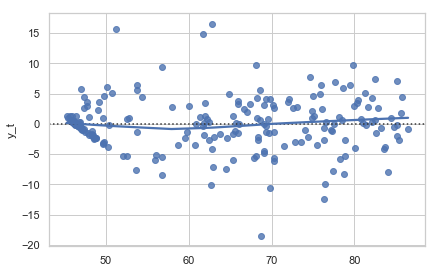

In [66]:
sns.set(style="whitegrid")

y_predict = gb.predict(X_train)

# Plot the residuals after fitting a linear model
sns.residplot(y_predict, y_train, lowess=True, color="b")

In [67]:
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='r2')
mse_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rmse = np.sqrt(-np.mean(mse_scores))

print("RF Scores")
print(np.mean(scores))
print(rmse)

RF Scores
0.8110963679172624
6.225618699744487


In [68]:
scores = cross_val_score(gb, X_train, y_train, cv=10, scoring='r2')
mse_scores = cross_val_score(gb, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rmse = np.sqrt(-np.mean(mse_scores))

print("RF Scores")
print(np.mean(scores))
print(rmse)

RF Scores
0.8085837385344142
6.19427423666639


   train_size  train_score  test_score
0          16     0.158469    0.017440
1          53     0.889881    0.783653
2          90     0.898012    0.800932
3         127     0.908562    0.815326
4         164     0.914125    0.823041


(-1, 1)

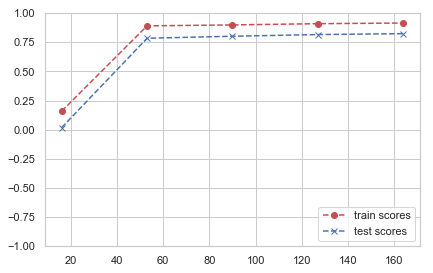

In [69]:
train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train, cv=4)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
print(learn_df)

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.legend(loc='lower right')
plt.ylim(-1,1)

   train_size  train_score  test_score
0          16     0.000000   -0.116815
1          53     0.957953    0.780113
2          90     0.946186    0.796795
3         127     0.933271    0.815331
4         164     0.921976    0.819755


(-1, 1)

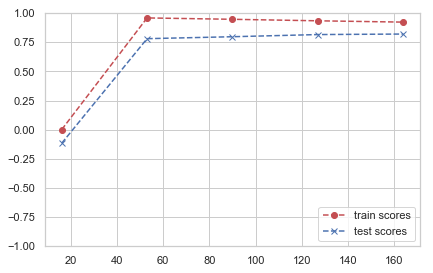

In [70]:
train_sizes, train_scores, test_scores = learning_curve(gb, X_train, y_train, cv=4)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
print(learn_df)

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.legend(loc='lower right')
plt.ylim(-1,1)

In [71]:
X_train.columns

Index(['First_Base', 'Second_Base', 'Third_Base', 'Shortstop', 'Left_Field',
       'Center_Field', 'Right_Field', 'DH', 'Runs_Scaled', 'Hits_Scaled',
       'Doubles_Scaled', 'Triples_Scaled', 'HR_Scaled', 'RBI_Scaled',
       'BA_Scaled', 'OBP_Scaled', 'SLG_Scaled', 'OPS_Scaled', 'SB_Scaled',
       'TB_Scaled', 'SF_Scaled', 'Age_Scaled', 'Total_games_played_Scaled',
       'dWAR_Scaled', 'All_star_count_Scaled', 'rootASC_Scaled'],
      dtype='object')

In [72]:
def feature_selection(model, X, y, count):
    # RANDOM FOREST FEATURE IMPORTANCE
    model.fit(X, y)    
    importances = list(zip(model.feature_importances_, X.columns))
    importances.sort(reverse=True)
    RF_features = [x[1] for x in importances][0:count]
    weights = [x[0] for x in importances][0:count]
    
    feats = pd.DataFrame(
        {
         'Feature Importances': RF_features,
            'Weights': weights
        })
    
    return feats

In [73]:
feature_selection(rf, X_train, y_train, len(X_train.columns))

,Feature Importances,Weights
0,Total_games_played_Scaled,0.810932
1,Doubles_Scaled,0.032254
2,Hits_Scaled,0.024358
3,OPS_Scaled,0.022020
4,RBI_Scaled,0.019814
5,TB_Scaled,0.019737
6,Runs_Scaled,0.014839
7,OBP_Scaled,0.012091
8,HR_Scaled,0.008466
9,BA_Scaled,0.007402


In [74]:
feature_selection(gb, X_train, y_train, len(X_train.columns))

,Feature Importances,Weights
0,Total_games_played_Scaled,0.395588
1,dWAR_Scaled,0.091676
2,OBP_Scaled,0.086465
3,SF_Scaled,0.069060
4,HR_Scaled,0.048224
5,Runs_Scaled,0.047002
6,Hits_Scaled,0.044983
7,Triples_Scaled,0.040985
8,Age_Scaled,0.039430
9,RBI_Scaled,0.030402


In [75]:
training_df.corr()

,Runs,Hits,Doubles,Triples,HR,RBI,BA,OBP,SLG,OPS,...,Third_Base,Shortstop,Left_Field,Center_Field,Right_Field,DH,Salary,log_salary,y_t,rootASC
Runs,1.000000,0.952016,0.921863,0.522089,0.794984,0.901047,0.375304,0.452044,0.373188,0.447963,...,0.038038,-0.017244,0.014587,0.016190,0.062249,0.066928,0.678559,0.706624,0.715791,0.676827
Hits,0.952016,1.000000,0.953036,0.507708,0.715878,0.893332,0.449801,0.399244,0.315299,0.384698,...,0.051213,0.032614,-0.022714,-0.029906,0.012670,0.064157,0.688901,0.744547,0.750115,0.666740
Doubles,0.921863,0.953036,1.000000,0.425870,0.729518,0.891904,0.409963,0.394282,0.358311,0.415827,...,0.106203,-0.011703,-0.014035,-0.065659,0.013132,0.054548,0.663336,0.713810,0.719812,0.650902
Triples,0.522089,0.507708,0.425870,1.000000,0.146114,0.276856,0.263860,0.125230,0.045353,0.079695,...,-0.053220,0.138741,0.080775,0.186183,0.098750,-0.142108,0.207633,0.286506,0.278638,0.211109
HR,0.794984,0.715878,0.729518,0.146114,1.000000,0.923620,0.208839,0.351632,0.591801,0.579163,...,0.081098,-0.123714,0.018918,-0.090712,0.055768,0.233357,0.583478,0.552996,0.568398,0.592420
RBI,0.901047,0.893332,0.891904,0.276856,0.923620,1.000000,0.338774,0.408037,0.490570,0.521970,...,0.092362,-0.064237,-0.009031,-0.108538,0.036067,0.170271,0.680111,0.678805,0.692177,0.666566
BA,0.375304,0.449801,0.409963,0.263860,0.208839,0.338774,1.000000,0.655835,0.577531,0.677539,...,0.064565,-0.035946,-0.005679,-0.051114,-0.005193,0.034762,0.322335,0.259883,0.276490,0.350941
OBP,0.452044,0.399244,0.394282,0.125230,0.351632,0.408037,0.655835,1.000000,0.519133,0.756506,...,0.023060,-0.115445,0.018682,-0.083277,0.024670,0.087364,0.397664,0.312823,0.333605,0.407177
SLG,0.373188,0.315299,0.358311,0.045353,0.591801,0.490570,0.577531,0.519133,1.000000,0.951685,...,0.101176,-0.154435,0.087966,-0.083366,0.051951,0.162347,0.281298,0.181874,0.202703,0.328427
OPS,0.447963,0.384698,0.415827,0.079695,0.579163,0.521970,0.677539,0.756506,0.951685,1.000000,...,0.085702,-0.159647,0.074021,-0.093709,0.048615,0.155612,0.358114,0.251556,0.274960,0.397594


In [76]:
X_train.columns

Index(['First_Base', 'Second_Base', 'Third_Base', 'Shortstop', 'Left_Field',
       'Center_Field', 'Right_Field', 'DH', 'Runs_Scaled', 'Hits_Scaled',
       'Doubles_Scaled', 'Triples_Scaled', 'HR_Scaled', 'RBI_Scaled',
       'BA_Scaled', 'OBP_Scaled', 'SLG_Scaled', 'OPS_Scaled', 'SB_Scaled',
       'TB_Scaled', 'SF_Scaled', 'Age_Scaled', 'Total_games_played_Scaled',
       'dWAR_Scaled', 'All_star_count_Scaled', 'rootASC_Scaled'],
      dtype='object')

In [77]:
X = X_train[['First_Base', 'Second_Base', 'Third_Base', 'Shortstop', 'Left_Field',
       'Center_Field', 'Right_Field', 'DH', 'RBI_Scaled','OPS_Scaled',
       'TB_Scaled', 'Age_Scaled', 'Total_games_played_Scaled',
       'dWAR_Scaled', 'rootASC_Scaled']]
y = y_train

In [78]:
## USING KFOLD CROSS VALIDATION

models = [LinearRegression(), SVR(), DecisionTreeRegressor(), RandomForestRegressor(),
           GradientBoostingRegressor()]
names = ['LinReg', 'SVR', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(n=len(X), random_state = 4444)
    rsquared = []
    rmse = []
    
    for train_index, test_index in kf:
        
        kX_train = X.iloc[train_index]
        kX_test = X.iloc[test_index]
        ky_train = y.iloc[train_index]
        ky_test = y.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        #R_squared score
        score = np.round(models[i].score(kX_test, ky_test), 4)
        # Make predictions using the testing set
        y_predict = models[i].predict(kX_test)
        # The mean squared error
        root_mse = np.round(np.sqrt(mean_squared_error(ky_test, y_predict)), 4)
        
        rsquared.append(score)
        rmse.append(root_mse)
        
    
    rsquared = np.round(np.mean(rsquared), 4)
    rmse = np.round(np.mean(rmse), 4)
    
    print('Scores with K-Fold CV')
    print(f'{names[i]} R^2 score: {rsquared} RMSE: {rmse}')
    print('')

Scores with K-Fold CV
LinReg R^2 score: 0.7622 RMSE: 6.9393

Scores with K-Fold CV
SVR R^2 score: 0.6802 RMSE: 8.2327

Scores with K-Fold CV
Decision Tree R^2 score: 0.6848 RMSE: 8.0707

Scores with K-Fold CV
Random Forest R^2 score: 0.7731 RMSE: 6.85

Scores with K-Fold CV
Gradient Boosted Trees R^2 score: 0.7812 RMSE: 6.7379



In [79]:
models = [('forest', RandomForestRegressor)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    grid.fit(X, y)
    mse_score = -1.0*grid.best_score_
    rmse_score = np.sqrt(mse_score)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}, rmse: {rmse_score}"
    print(s)
    grids[name] = grid

forest: best score: -38.14438386149923, best estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False), rmse: 6.176113977372765


In [80]:
rf2 = grid.best_estimator_
rf2.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [81]:
models = [('GBT', GradientBoostingRegressor)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring = 'neg_mean_squared_error')
    grid.fit(X, y)
    mse_score = -1.0*grid.best_score_
    rmse_score = np.sqrt(mse_score)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}, rmse: {rmse_score}"
    print(s)
    grids[name] = grid

GBT: best score: -39.16491015910431, best estimator: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=25, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False), rmse: 6.258187449981369


In [82]:
gb2 = grid.best_estimator_
gb2.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=25, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

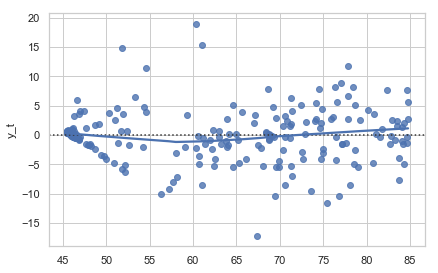

In [83]:
sns.set(style="whitegrid")

y_predict = rf2.predict(X)

# Plot the residuals after fitting a linear model
sns.residplot(y_predict, y, lowess=True, color="b")

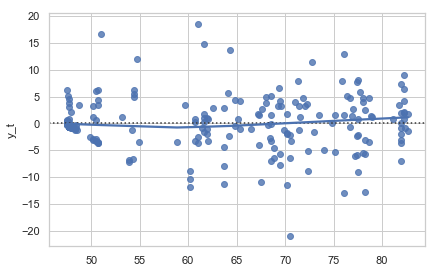

In [84]:
sns.set(style="whitegrid")

y_predict = gb2.predict(X)

# Plot the residuals after fitting a linear model
sns.residplot(y_predict, y, lowess=True, color="b")

In [85]:
scores = cross_val_score(rf2, X, y, cv=10, scoring='r2')
mse_scores = cross_val_score(rf2, X, y, cv=10, scoring='neg_mean_squared_error')
rmse = np.sqrt(-np.mean(mse_scores))

print("RF2 Scores -- Less Features")
print(np.mean(scores))
print(rmse)

RF2 Scores -- Less Features
0.8140152865882246
6.231563150044172


In [86]:
scores = cross_val_score(gb2, X, y, cv=10, scoring='r2')
mse_scores = cross_val_score(gb2, X, y, cv=10, scoring='neg_mean_squared_error')
rmse = np.sqrt(-np.mean(mse_scores))

print("GB2 Scores -- Less Features")
print(np.mean(scores))
print(rmse)

GB2 Scores -- Less Features
0.8051073181145089
6.248526878148321


   train_size  train_score  test_score
0          16     0.288420    0.143707
1          53     0.875812    0.773822
2          90     0.892460    0.792821
3         127     0.898345    0.815423
4         164     0.898391    0.829328


(-1, 1)

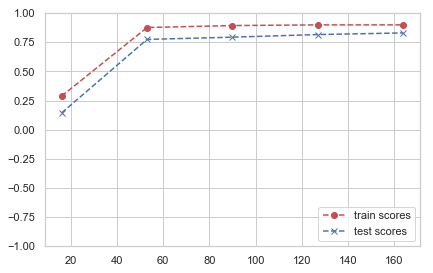

In [87]:
train_sizes, train_scores, test_scores = learning_curve(rf2, X, y, cv=4)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
print(learn_df)

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.legend(loc='lower right')
plt.ylim(-1,1)

   train_size  train_score  test_score
0          16     0.000000   -0.116815
1          53     0.915628    0.788310
2          90     0.901146    0.804359
3         127     0.892553    0.821358
4         164     0.881520    0.816957


(-1, 1)

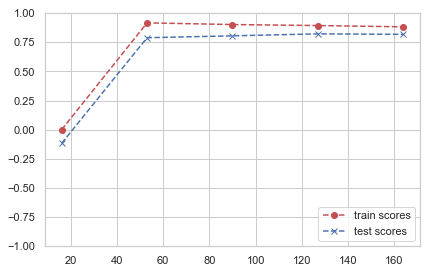

In [88]:
train_sizes, train_scores, test_scores = learning_curve(gb2, X, y, cv=4)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
print(learn_df)

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.legend(loc='lower right')
plt.ylim(-1,1)

In [89]:
feature_selection(rf2, X, y, len(X.columns))

,Feature Importances,Weights
0,Total_games_played_Scaled,0.827123
1,RBI_Scaled,0.080395
2,TB_Scaled,0.048205
3,OPS_Scaled,0.022891
4,dWAR_Scaled,0.010101
5,Age_Scaled,0.005718
6,rootASC_Scaled,0.004142
7,First_Base,0.000742
8,Second_Base,0.000426
9,Shortstop,0.000257


In [90]:
feature_selection(gb2, X, y, len(X.columns))

,Feature Importances,Weights
0,Total_games_played_Scaled,0.728890
1,OPS_Scaled,0.079398
2,rootASC_Scaled,0.074841
3,TB_Scaled,0.050129
4,RBI_Scaled,0.042053
5,dWAR_Scaled,0.024689
6,Third_Base,0.000000
7,Shortstop,0.000000
8,Second_Base,0.000000
9,Right_Field,0.000000


In [91]:
X_FINALTEST = X_FINALTEST[['First_Base', 'Second_Base', 'Third_Base', 'Shortstop', 'Left_Field',
       'Center_Field', 'Right_Field', 'DH', 'RBI_Scaled','OPS_Scaled',
       'TB_Scaled', 'Age_Scaled', 'Total_games_played_Scaled',
       'dWAR_Scaled', 'rootASC_Scaled']]

In [92]:
from scipy.special import inv_boxcox

def regression_scores(model,x,y):
    Final_mse_scores =[]
    final_r2_scores = []
    y_test_predict = model.predict(x)
    score = mean_squared_error(inv_boxcox(y_test_predict, lamb), inv_boxcox(y, lamb))
    rmse = score**0.5
    Final_mse_scores.append(rmse)
    r2 = r2_score(y_test_predict, y)
    final_r2_scores.append(r2)

    y_ticks = [0, .5e7, 1e7, 1.5e7, 2e7, 2.5e7, 3e7]
    salaries = ['0', '5,000,000', '10,000,000', '15,000,000','20,000,000','25,000,000','30,000,000']
    plt.subplot(1, 1, 1)
    plt.scatter(inv_boxcox(y, lamb), inv_boxcox(y_test_predict, lamb))
    
    
    plt.title('Predicted baseball salaries versus actual')
    plt.ylabel('Predicted Salary')
    plt.xlabel('Actual Salary')
    plt.yticks(y_ticks, salaries)
    plt.xticks(y_ticks, salaries, rotation=30)
    plt.plot([0, 3e7], [0, 3e7], color='red');
    
    mean_mse = np.mean(Final_mse_scores)
    return ('Mean RMSE', np.mean(Final_mse_scores), 'Mean R^2',np.mean(final_r2_scores))

('Mean RMSE', 3080126.2678366913, 'Mean R^2', 0.8893092367479549)

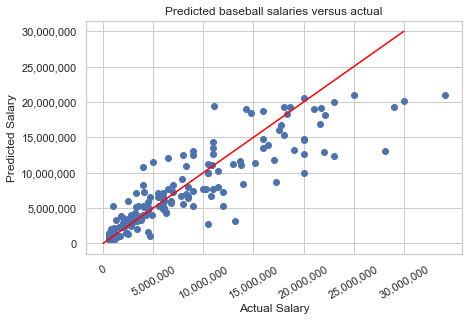

In [93]:
## SCORES ON THE TRAINING SET

regression_scores(rf2, X, y)

('Mean RMSE', 4014470.8277192796, 'Mean R^2', 0.6449196046636028)

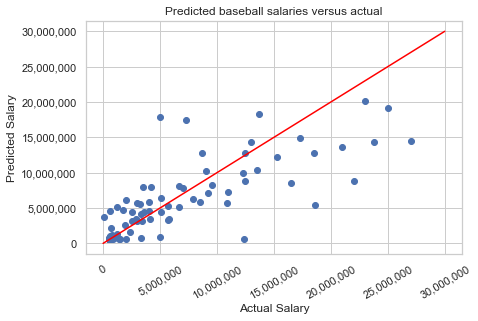

In [95]:
## SCORES ON THE TRAINING SET

regression_scores(rf2, X_FINALTEST, y_FINALTEST)